In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import finalplots
import finalmodel

# Walmart: Trip Type Classification

## Business Understanding

### What problem are we trying solve?

The problem we are trying to solve as explained on Kaggle is:

*“Walmart uses both art and science to continually make progress on their core mission of better understanding and serving their customers. One way Walmart is able to improve customers' shopping experiences is by segmenting their store visits into different **trip types**.*

*Whether they're on a last-minute run for new puppy supplies or leisurely making their way through a weekly grocery list, classifying trip types enables Walmart to create the best shopping experience for every customer.*

*Currently, Walmart's **trip types** are created from a combination of existing customer insights ("art") and purchase history data ("science"). In their third recruiting competition, Walmart is challenging Kagglers to focus on the (data) science and **classify customer trips** using only a **transactional dataset** of the items they've purchased. Improving the science behind trip type classification will help Walmart refine their segmentation process.”*

Accordingly, we are trying to solve a **multi-class classification problem**.

In particular, Walmart has categorized the trips contained in the data set into **38 distinct types** using a proprietary method applied to a more extended set of data.

*The problem is made more challenging because the **trip types** are simply identified with numbered labels, products are also identified by number (although some higher-level department descriptions are also provided) and the data set provided is more restricted than the data set used to classify the trip types.* 

### What are the relevant metrics? How much do we plan to improve them?

As the problem is a **multi-class classification problem** the model is evaluated using **multi-class logarithmic loss**, which has to be minimized. As previously shown our baseline model produced a private score of 3.16, which would have positioned our model at a rank of 727 out of 1047. Our aim was to improve our score to at least get in the top quartile, so we needed to lower the log-loss score to 0.73 or lower. We didn't quite achieve this, but we did manage to get it down to 0.91 or a rank of 380, so marginally outside the top quartile. 

### What will we deliver?

We proposed delivering a machine learning model that (given the available inputs below) best predicts Walmart’s specified Trip Types. This report shows our process of identification of our best model.

## Data Understanding

### What are the raw data sources?

The raw data is sourced from Walmart’s transactional data set of items their customers have purchased on a number of individual visits.

### What does each 'unit' (e.g. row) of data represent?

Each unit in the data set represents a unique product type that was purchased by a single customer as part of their broader single trip to Walmart, i.e. it represents one product class in their overall visit basket (there is a field (ScanCount) in the row that identifies the number of items of the product that were purchased or returned).

### What are the fields (columns)?

Walmart explains the data fields (columns) as follows:

- **TripType:** A categorical ID representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.

- **VisitNumber:** An ID corresponding to a single trip by a single customer

- **Weekday:** The weekday of the trip

- **Upc:** The UPC number of the product purchased

- **ScanCount:** The number of the given item that was purchased. A negative value indicates a product return.

- **DepartmentDescription:** A high-level description of the item's department.
 
- **FinelineNumber:** A more refined category for each of the products, created by Walmart.

Some comments:

- **TripType:** As mentioned above this is a categorical variable that includes **38 distinct numbered trip types**, which is the target of the model.

- **VisitNumber:** Within the data set there are 95,674 unique visit number IDs.

- **Weekday:** Is a simple categorical variable identifying the day of the week the visit occurred.

- **ScanCount:** Is the number of items of the given product type that were purchased or returned on the individual shopping trip. If the product was returned the number of items have a negative sign. Some models such as MultinomialNB don't accept negative feature values, so when testing these models we had to change their **ScanCount** to zero resulting in some loss of information. These models were not found to be the best for this problem, so the negative values were retained for other models tested.

- The other fields are all categorical variables identifying at varying levels the type of product being purchased or returned. One level is a numerical product level classification (**Upc**), another is a more summarized Walmart defined numerical product level classification (**FinelineNumber**) and the highest-level product classification are text based categories (**DepartmentDescriptions**), which can easily be converted to dummy variables, but using ScanCount instead of 1 or 0, i.e. the number of items purchased or returned.

In [2]:
p1, p2, p3, p4, p5, p6, p7 = finalplots.plots()

### EDA

#### Distribution of each feature

##### Weekday:

We plot the number of visits by week day. Frequency is higher on Friday, Saturday and Sunday, which is what you would intuitively expect, so the data set would appear to be a slice across time with equal numbers of days of the week. Accordingly, there doesn’t appear to be anything concerning with the distribution of the data with respect of week days of visits.

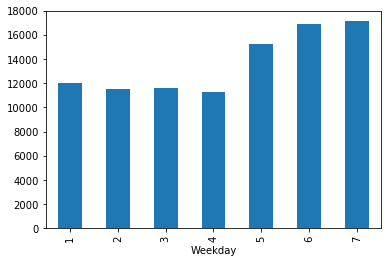

In [3]:
p1.plot.bar('Weekday','VisitNumber', legend=False)

##### ScanCount:

We plot the frequency of the number of each product type in each shopping basket across all visits. As can be seen one item is by far the most common number of items of a product in a shopping basket.

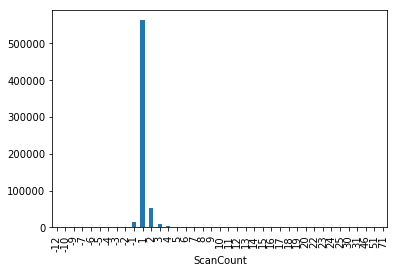

In [4]:
p2.plot.bar('ScanCount','TripType', legend=False)

It is hard to see in the chart above, but as shown below the frequency declines exponentially as the number of each product item in the shopping basket rises.

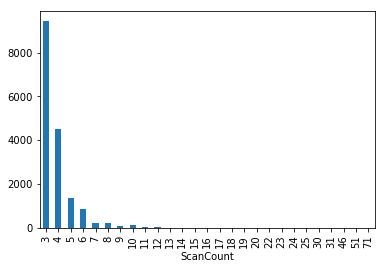

In [5]:
p3.plot.bar('ScanCount','TripType', legend=False)

The same general relation is found for items being returned, i.e. negative ScanCount, but on a much lower frequency scale. 

Accordingly, the data is as you would intuitively expect and this distribution will need to be considered when looking at variable normalization because many features will be derived from the ScanCount field.

##### NumItems

The following chart, which uses an aggregation explained below, plots the histogram of the number of individual items in each shopping basket across the ~650K unique visit numbers. 


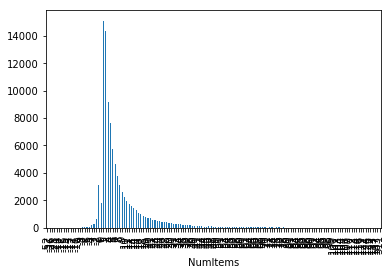

In [6]:
p4.plot.bar('NumItems','TripType', legend=False)

##### NumProducts:

The following chart, which uses an aggregation explained below, plots the histogram of the number of individual products in each shopping basket across the ~650K unique visit numbers. 

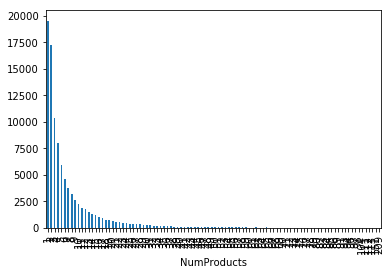

In [7]:
p5.plot.bar('NumProducts','TripType', legend=False)

#### Missing values

As shown below a simple count of null values indicates that the only missing values in the data set relate to product IDs, i.e. Upc product numbers and hence consequently their FinelineNumber and DepartmentDecription.



In [8]:
p6

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

There are 4,129 rows with null values out of X. Our exploratory analysis indicates nothing systematic about the null values.  

We replace null values in the data set with ‘Unknown’ to effectively create an extra product classification in each of the three levels of product identification.




#### Distribution of target

A histogram of the target classifications is shown in the chart below. As can be seen the target frequencies are not evenly distributed across the classifications. In particular, a number of the classifications appear in the training data set with quite low frequency, so this will potentially make prediction of these classifications quite difficult.

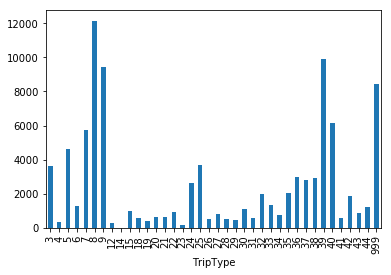

In [9]:
p7.plot.bar('TripType','NumItems', legend=False)

#### Relationships between features

The primary features for this problem are derived from the **ScanCount** field such as number of items or products in the basket or number of items by product classification.

#### Other idiosyncracies?

There are a few other idiosyncracies about this particular problem:

- The negative values for returned items are a peculiarity of this particular problem. It is interesting to consider the influence of the returned item/s on the **TripType**. Is the returned item the cause of the trip? If so does it lead to different sized baskets than otherwise. To take account of this trip characteristic we include a basket-includes-a-returned-item dummy to capture their influence in more detail. 

- Many machine learning models are founded on the assumption of independence of observations assumptions, e.g. Naïve Bayes. Such an assumption is quite flawed in this instance because the combination of the items in the baskets are what enable trip type prediction, i.e. items in the basket are dependent on each other because of the trip type.

- The unique products in the train and test data sets are not the same, i.e. there are around 25K different unique products between the two data sets so making predictions about individual unknown products could be difficult. However, there is no difference at the department level, so modelling at the department level will likely produce better results.




## Data Preparation

### What steps are taken to prepare the data for modeling?

Data analysis shows that there are just under 100,000 product items at the Upc level, so if you treat each Upc product as a feature you end up with a matrix of around 100,000 visits by 100,000 products most of which are zero entries, i.e. each shopping basket only has a very small number of all the possible products. Accordingly, a primary preparation of the data set is to load the data into Sparse Compressed Row format.

Initial model fits of a default Logistic Regression indicate that optimization of model even just across the 69 Departments is time consuming.

For example, intending to use a feature set with only department level product counts, we accidentally used the full feature set with around 100K features and ~12 hours later on a MacBook Pro it finished!. For this run the our baseline model produced a log-loss score of 0.07 (compared to the competition winner on 0.48!) when optimized on the full training set and using no cross validation, so no surprises that it didn’t generalize that well to the test data set hence the test score of 3.15 on Kaggle.

While for Naïve Bayes it is very fast and can in fact be easily optimized over the lowest level Upc product classification, however leads to overfitting and does not generalize well due to the large number of new products in the test data set.

### Feature transformations? engineering?

We transform the data to create a number of new features from the data set that intuitively relate to the type of shopping trip being made. In particular: 

- **Weekday:** We convert the categorical Weekday variable into a numerical variable where Monday converts to 1 and Sunday to 7 as there are likely to be quite different shopping trip types on different days.

- **Return:** We construct a dummy variable (Return) that denotes whether there was an item returned as part of the shopping trip, i.e. one of the items had a negative ScanCount. We have done this because trips with a returned item may have different characteristics to trips without a returned item, e.g. they may be of smaller size that non-return trips.

We also performed **feature scaling** to normalize relative feature magnitudes across all the features. In doing so we faced a problem with the sparsity of our feature set, i.e. the large number of zeros in the feature set, because z-score style normalisations that de-mean the feature sets make the feature set dense and change the important meaning of zero in the feature set, i.e. that no product was purchased. Accordingly, the used the AbsMaxScaler function, which scales the values to be in the range [-1, 1] by dividing all the values in the each feature by the maximum absolute value of the feature. This scaling method retains zeros as zeros, so maintains both their important meaning and the data sparsity. We found some value in using this scaled data for some models, but because of the nature of the scaling method found that it added no value on decision tree/gradient boosting based models. Accordingly, it was not used on the feature set in our best model

Further given the large number of features in the data set we also explored **dimensionality reduction** using Principal Component Analysis (PCA), however, scikit-learn's PCA doesn't support sparse matrix input, so we used TruncatedSVD instead. As explained in the documentation:

*This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.*

Using this transformer we found that we were able to explain ~98% of the variability in the feature set using only an 8 component model specification. Despite being able to reduce the dimensions of the data to a small number of components we didn't find much benefit in the various models that we ran. Accordingly, despite testing this avenue it was not used in our best model.


### Table joins? Aggregation?

Following on from the previous section we also further engineered some other features that used aggregations.

In particular, as discussed above the unit in the data set is a description of one product in a given shopping basket or visit, so it is necessary to use aggregations of the **ScanCount** field, i.e. the number of items of the product in the shopping basket, across the other fields to end up with a table describing each shopping visit.

- **NumProducts/NumItems:** We first aggregate the ScanCount field by the VisitNumber field, using sum() and count() to work out the number of products (NumProducts) and items (NumItems) in each shopping basket, this will help to differentiate between big weekly shop trip types versus say a trip type to grab an item you might be missing for a recipe on the weekend.

- **Product Aggregate Dummies:** We then aggregate **ScanCount** using sum() across each of the more aggregated product categories, i.e. **FinelineNumber** and **DepartmentDescription**, to determine the number of items purchased in these classifications for dummy variable style feature construction. EDA analysis showed that there were too many **FinelineNumbers** that appeared in the test data set but not in the training data set for the model to generalise well. Accordingly, the best model used product aggregations at the Department Description level only.

??? Association Rules?


### Precise description of modeling base tables.

#### What are the rows/columns of X (the predictors)?

##### Rows:

- **VisitNumber:** The rows in the base features table are the unique shopping visits that we are trying to predict their trip type.

##### Columns:

The columns in the base features table are:

- **NumItems:** Is the number of individual items in the shopping basket.

- **NumProducts:** Is the number of individual products in the shopping basket.

- **Return:** Is a dummy indicating whether the shopping basket includes a returned item or not.

- **Weekday:** A numerical categorical value to indicate the day of the shopping visit.

- **DepartmentDescription:** A set of 69 features indicating which department the product comes from and how many units of the product were purchased or returned.

- **FinelineNumber:** A set of ~5,300 features indicating which FinelineNumber category (a more granular version of DepartmentDescription) the product comes from and how many units of the product were purchased or returned. Due to impact on processing time and model generalisation these features are not used in the best model.

#### What is y (the target)?

The target is the field **TripType**. It is a categorical ID representing the type of shopping trip the customer made. Walmart has categorized the trips contained in the data set into **38 distinct types** using a proprietary method applied to a more extended set of data. It is the ground truth that we are predicting. TripType_999 is an "other" category.


## Modeling

### What model are we using? Why?

Our baseline model used a default Logistic Regression because it generally performs reasonably well in most scenarios and it offers inbuilt multi-class functionality with log loss scoring. However, given the style of problem, which relates to how shopper decide to combine various numbers of discrete products into a shopping basket/trip, the feature set lends itself well to decision tree style analyses. Accordingly, we primarily focused on using decision tree, random forest and gradient boosting models. Overall, we found incremental gains in minimizing the log loss function and improving our prediction accuracy as we progressed through these testing each of these models. **Accordingly, our best model uses the scikit-learn GradientBoostingClassifier.**

### Assumptions?

Given the large magnitude of the feature set run time for some of these models, in particular the gradient boosting models was quite long, so we first focused on one of the primary parameters for optimization, the **max_depth** parameter, which limits the number of nodes in the tree. We found that increasing this parameter from 1 through 7 quickly led to overfitting problems.

In fact overfitting was a problem with all models because shopping trip baskets likely have a number of products consistent with the actual shopping trip type, but then have some random products unrelated to the core trip type which cause noise, false signals and hence prediction difficulties.

Having honed in on a **max_depth** value of 3, we then focused on **min_samples_leaf** and **max_leaf_nodes** parameters. In regards to these parameters we were cognisant that there were a minimum of 4 of one Trip Type in our EDA and there are 38 distinct trip types being predicted so we tested a models around these parameters.

Overall run times were slow and ipython notebook kernels dying was a common problem with the size and dimensions of our data set, so it was hard to implement detailed pipelines to explore greater optimization of the parameters.

We note that with some improving w205 Amazon Web Services knowledge under our belts (our other class this semester) this problem could be better handled on a larger instance in the cloud. We also note that the xgboost package in Python, which is well reviewed on the internet may also help to improve performance 


### Regularization?

For the scikit-learn GradientBoostingClassifier the primary regularization parameter is the **learning_rate**, which is set at a healthy default rate of 0.1.

We did not make use of the max_features parameter, which also can act as a regularization approach, we simply used the default setting of None.

### Best model

In the end after all the data analysis, feature engineering and various models tested the best model we found was based on the GradientBoostingClassifier in scikit-learn with max_depth=3, learning_rate=0.1, min_samples_leaf=4 and max_leaf_nodes=40.


## Evaluation

### How well does the model perform?

The model is evaluated on the basis of a **multi-class log loss score**, some classifiers have this as a default scoring option, while others don’t, so we derive our own one for use when there isn’t one as follows:

```
from sklearn import metrics
my_log_loss = metrics.make_scorer(metrics.log_loss, greater_is_better=False, needs_proba=True)
```

In [ ]:
logloss, F1_score = finalmodel.main()
print "Our final model produces a log loss score of 0.91 on the test set after having achieved a log loss score of", logloss, "on the training data set. The test data set score is down from our baseline model score of 3.15, so we made a reasonable improvement."

(95674, 130127)
(95674, 79)
(95674, 130127)
(95674, 79)


### Accuracy

In [ ]:
print "The F1 score of our best model is:", F1_score

No test score equivalent is given by Kaggle as it is not a metric of interest to the submission. It suggests there would still be some decent room for improvement. It would be interesting to know what F1 score the winner got.

### Cross-validation

Using a grid search default cross validation process it ran into difficultly when we tried to use more than 4 folds, because the minimum number of target trip types were 4 for trip type 14. Grid search would not allow more folds than 4 we assume so that it could make each fold representative of the full sample. For the most part we followed the recommended approach of using the full data set to fit the models.

## Deployment

### How is the model deployed?

The model is deployed to Walmart via Kaggle in in their specified submission format.

In particular, you must submit a csv file with the **VisitNumber** (from the test data), all the 38 candidate **TripType** classes, and a probability for each class, i.e. a predicted probability matrix of shape (95,584, 38). The order of the rows does not matter. The file must have a header and look like the following:

"VisitNumber","TripType_3","TripType_4",...
1,0,0.1,...
2,1,0,...
etc.

It is noted that the submitted probabilities for a given visit are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, predicted probabilities are replaced with *max(min(p,1−10e−15),10e−15)*. Notably this probability condition is the default setting in the scikit learn log-loss metric.

The submission file format is easily created using the predict_proba() function for fitted classifiers in scikit learn, which returns a predicted probability for each class for each example in the data set.